# <center> Audio Classification AI Project
The goal of this notebook is to document the process of completing this project including research, implementation ideas and outcomes. This is also my first project dealing with signal analysis and machine learning so my learning process is also documented here.

## Overview
The final goal of this project is to develop and train a model to classify various audio samples, in particular those used in music production. Samples of particular interest include the following classes: kicks, snares, claps, hihats, and crashes. 

There are a few notable challenges with dealing with these sounds. First, these each of these sounds can occupy diverse frequency ranges. For example, kick drums often fall between 50 Hz to 600 Hz, snares fall between 150 Hz to 3 kHz
, and hihats begin their range from around 2 kHz and can reach as high as 30 kHz (basically inaudible to humans at that point). Therefore, it is inadequate to classify these sounds based solely their respective periodograms. A way to account for this is by performing additional processing on the signal using STFT to obtain a spectrogram. 

Another challenge is the duration range of the samples. Samples like crashes often last a couple of seconds while hihats may last a fraction of a second. This complicates feature extraction since the obtained spectrograms will be different lengths for different input durations. Forms of padding and trimming must be implemented in a way that they do not corrupt or impart  ambiguity to the signal.

## Reading in files
There are a plethora of modules available for reading and parsing wav files. An issue that I encountered was that many of these existing modules do not support 24 bit/sample audio format or files encoded using a non-PCM format. While the latter is less of an issue since most audio samples are short and uncompressed, the former poses a bigger problem since the bitrate of audio samples varies alot. I wrote my own parser *read_wave(path, normalize=True, length=1, threshold=0.001)* which allows me to read wav files of any bitrate. It also has the benefit of preprocessing the audio (normalizing frame data, applying a signal envelope, cutting audio to meet a maximum duration, etc.) which can be tuned via some optional arguments.

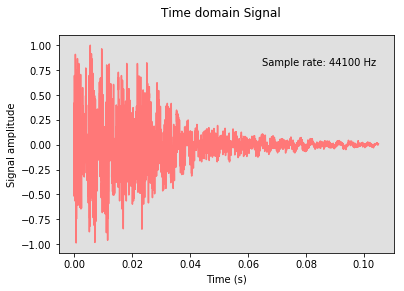

In [7]:
import sys
sys.path.append('../')

from read_wave import *
import matplotlib.pyplot as plt

path = "wav_files/Claps/1.wav"

signal, sr = read_wave(path)

frames = range(len(signal))
time = [frame / sr for frame in frames]

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time, signal, '#ff7878')
ax.set_facecolor('#e0e0e0')
ax.set_ylabel("Signal amplitude")
ax.set_xlabel("Time (s)")
fig.suptitle("Time domain Signal")
plt.annotate(s='Sample rate: '+ str(sr) + ' Hz', xy=(.065,.8))

plt.show()

## Feature Extraction
I created a feature extraction object that computes spectral density of a signal in its entirety, the filterbank energies of the signal, and MFCCs of the signal. To get a better understanding of what these computations do, I decided to personally implement some of these features.
### Spectral Density
FFT calculations were performed using NumPy. Based on the signal input, we can show the frequency-domain representation. Note that the response is cut off after 22.050 kHz. This is because the sampling rate of the signal is 44.1 kHz and thus only signals with frequencies below half of that 44100 Hz (nyquist frequency) can be represented.

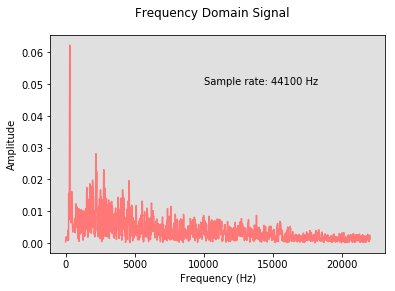

In [2]:
import numpy as np
def calcFFT(signal, sr):
        freq = np.fft.rfftfreq(len(signal), d=1/sr)
        full_fft = np.fft.rfft(signal)
        response = abs(full_fft / len(full_fft)) # normalize (can also try len(full_fft) or max(abs(full_fft)))
        return (response, freq)
y, x = calcFFT(signal, sr)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y, '#ff7878')
ax.set_facecolor('#e0e0e0')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Frequency (Hz)")
fig.suptitle("Frequency Domain Signal")
plt.annotate(s='Sample rate: '+ str(sr) + ' Hz', xy=(10000, 0.05))
plt.show()

### Filterbank Energies
In order to analyze the frequency behavior of a signal over time, the signal can be framed into smaller sections so the Short-time Fourier Transform can be applied across the entire signal. Thus each "frame" (roughly 20 data points) has a unique frequency domain representation which can be visually stacked over time to yield a spectrogram. There are a number of steps involved in this process:
1. Divide the signal into equal sized frames
2. Apply the FFT on each frame
3. Create filterbanks that are equally spaced on the mel-scale
4. For each frame, compute the energy under each filter 
5. Take the log of the filter energy values

#### Framing the signal
The frames are defined in a way so that the data captured in each frame overlaps with its adjacent frames. This is done to smoothly represent the changes in the frequency energies. You can visualize the structures of the frames below.

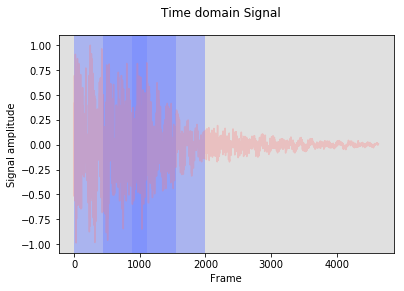

In [3]:
frame_length = 0.025 # in seconds
frame_offset = 0.01
samplesPerFrame = math.ceil(sr * frame_length)
offsetPerFrame  = math.ceil(sr * frame_offset)

range1 = (0, 0 + samplesPerFrame)
range2 = (range1[0] + offsetPerFrame, range1[0] + offsetPerFrame + samplesPerFrame)
range3 = (range2[0] + offsetPerFrame, range2[0] + offsetPerFrame + samplesPerFrame)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(signal, '#ff7878', alpha=0.3)
ax.set_facecolor('#e0e0e0')
ax.set_ylabel("Signal amplitude")
ax.set_xlabel("Frame")
fig.suptitle("Time domain Signal")

plt.axvspan(range1[0], range1[1], alpha=0.5, facecolor="#758aff")
plt.axvspan(range2[0], range2[1], alpha=0.5, facecolor="#758aff")
plt.axvspan(range3[0], range3[1], alpha=0.5, facecolor="#758aff")

plt.show()

#### Using the Mel Scale
The Mel scale is used to portray the relatively perceptive changes in pitch for the human ear. People do not naturally process changes in pitch on a linear scale. It is much easier to tell the difference between sounds at low frequencies then it is at higher frequencies; that is to say that we are more sensitive to lower frequency sounds. So when we build the ranges of the frequency banks, we want them to correspond to the Mel scale to better reflect how humans hear.

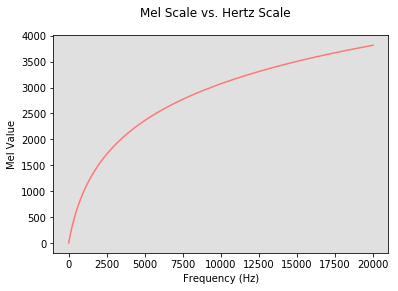

In [4]:
def mel(f):
    return 2595 * math.log(1 + f / 700, 10)

def imel(m): # inverse mel
    return 700 * (10**(m/2595) - 1)

f = range(0, 20000)
m = [mel(x) for x in f]

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(f, m, '#ff7878')
ax.set_facecolor('#e0e0e0')
ax.set_ylabel("Mel Value")
ax.set_xlabel("Frequency (Hz)")
fig.suptitle("Mel Scale vs. Hertz Scale")
plt.show()

#### Creating Filterbanks
Typically 26 triangular filter are used to capture the cepstrum of the input signal. These filters are spaced evenly on the Mel scale and overlap similar to the way the signal is framed in the time domain. Lets take a look at these filters plotted on the Mel scale and the Hertz scale.

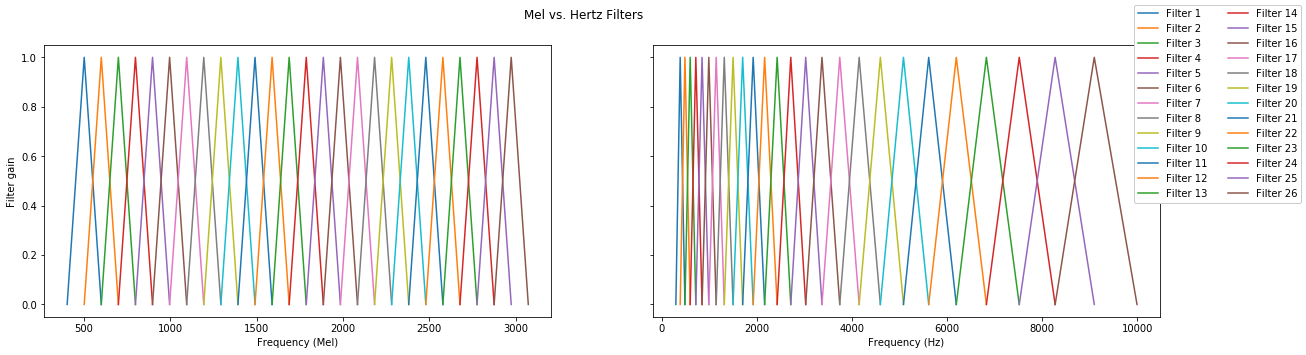

In [5]:
lowFreq = 300 # in Hz
hiFreq = 10000

lowMel = mel(lowFreq)
hiMel = mel(hiFreq)

numFilters = 26
melSpacing = (hiMel - lowMel) / (numFilters + 1)

melFilterDivisions = [lowMel + x * melSpacing for x in range(numFilters + 2)]
melFilters = [(melFilterDivisions[i-1], melFilterDivisions[i], melFilterDivisions[i+1]) for i in range(1, numFilters + 1)]
    
freqFilterDivisions = [math.floor(imel(x)) for x in melFilterDivisions]
freqFilters = [(freqFilterDivisions[i-1], freqFilterDivisions[i], freqFilterDivisions[i+1]) for i in range(1, numFilters + 1)]

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))
ax[0].set_ylabel("Filter gain")
ax[0].set_xlabel("Frequency (Mel)")
ax[1].set_xlabel("Frequency (Hz)")
fig.suptitle("Mel vs. Hertz Filters")

gain = [0, 1, 0]

for filter in melFilters:
    ax[0].plot(filter, gain)

for filter in freqFilters:
    ax[1].plot(filter, gain)
fig.legend(["Filter " + str(x) for x in range(1, 27)], loc='upper right', ncol=2, framealpha=1)
plt.show()

The energy under each filter is the sum of the cepstrum points weighted by the value of the filter

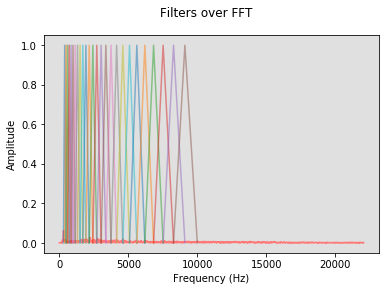

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y, '#ff7878')
ax.set_facecolor('#e0e0e0')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Frequency (Hz)")
fig.suptitle("Filters over FFT")

for filter in freqFilters:
    ax.plot(filter, gain, alpha=0.5)
plt.show()

#### Creating the spectrogram and MFCC
For each frame of the signal, 26 filterbank energies are calculated and can then be stacked adjacently to form the spectrogram of the signal. The MFCC is computed by taking the discrete cosine transform of the filterbank energies and discarding the upper 13 values. I used a feature extractor object to perform all of these computations and below are the plots of several samples: 

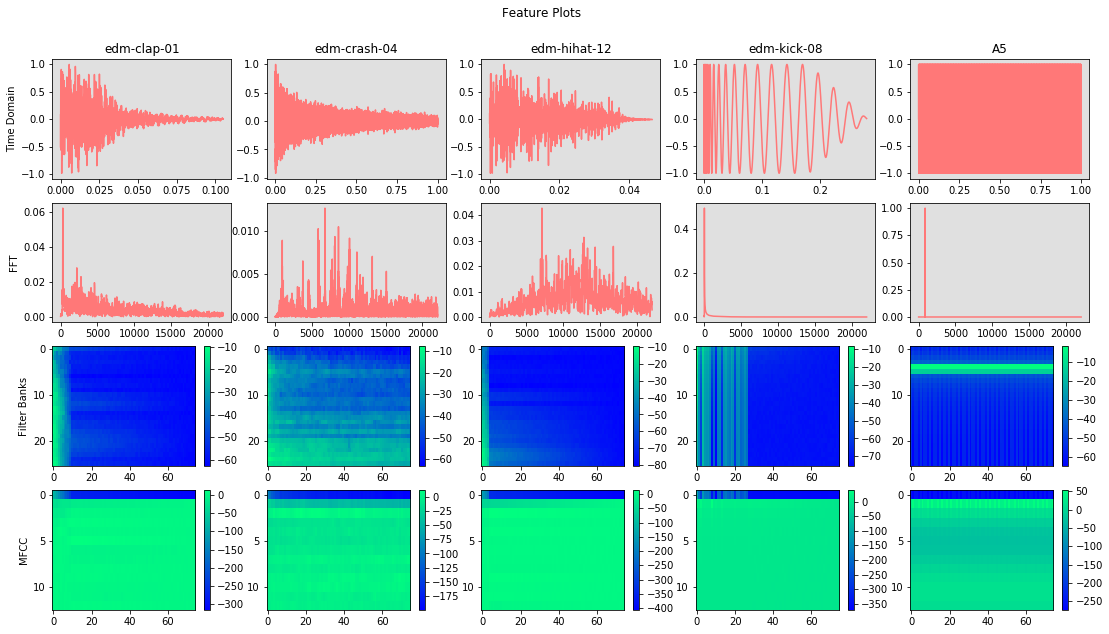

In [7]:
from plot_manage import *

plot_test_files(progressBar=False)
plt.show()

The spectogram visualization for these different samples allows for these sounds much more recognizable when compared to the time domain visualization. Samples of the same class also have very similar cepstral representations:   

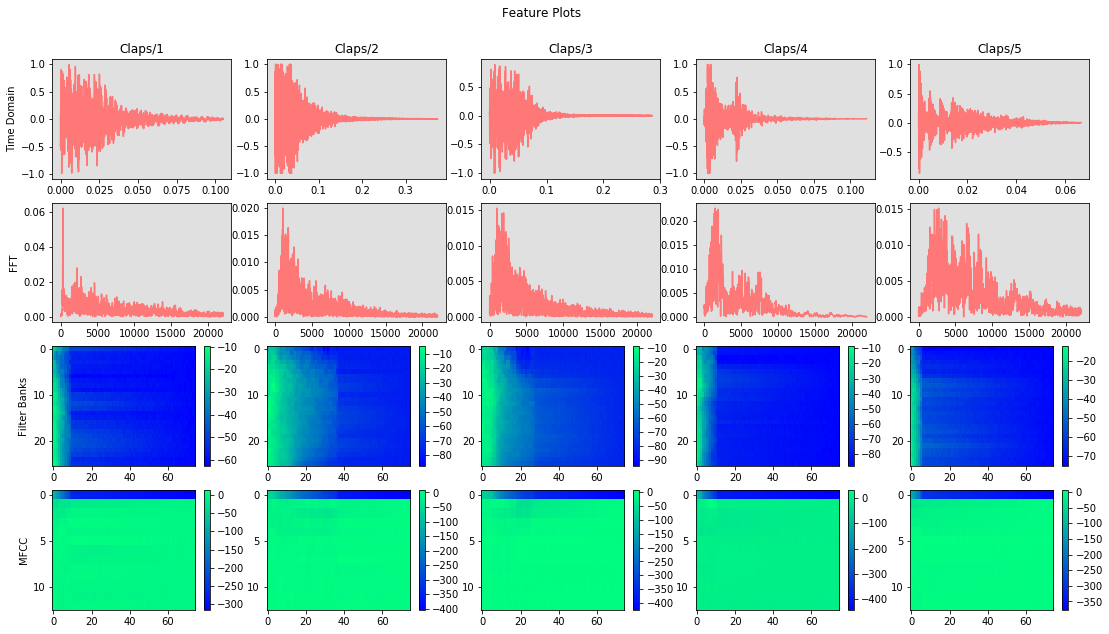

In [8]:
plot_claps(progressBar=False)
plt.show()

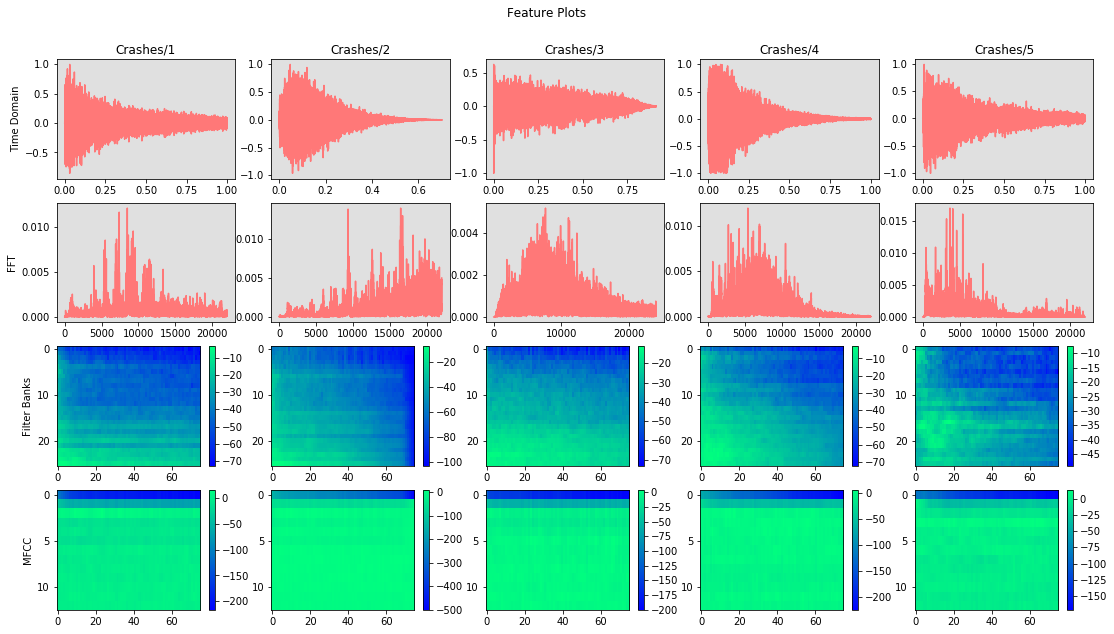

In [9]:
plot_crashes(progressBar=False)
plt.show()

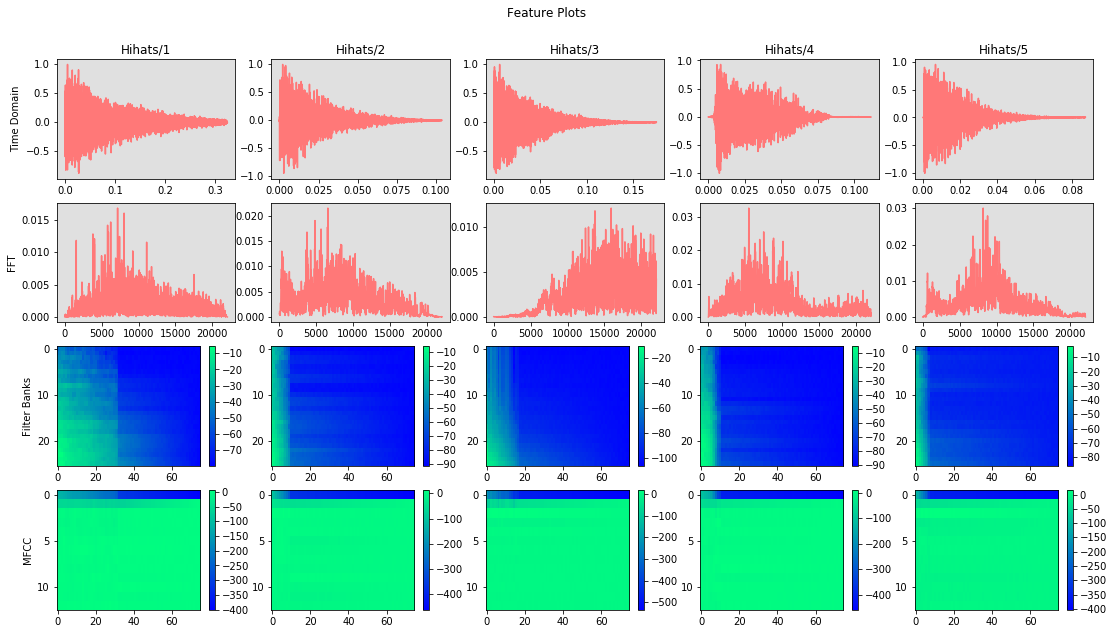

In [10]:
plot_hihats(progressBar=False)
plt.show()

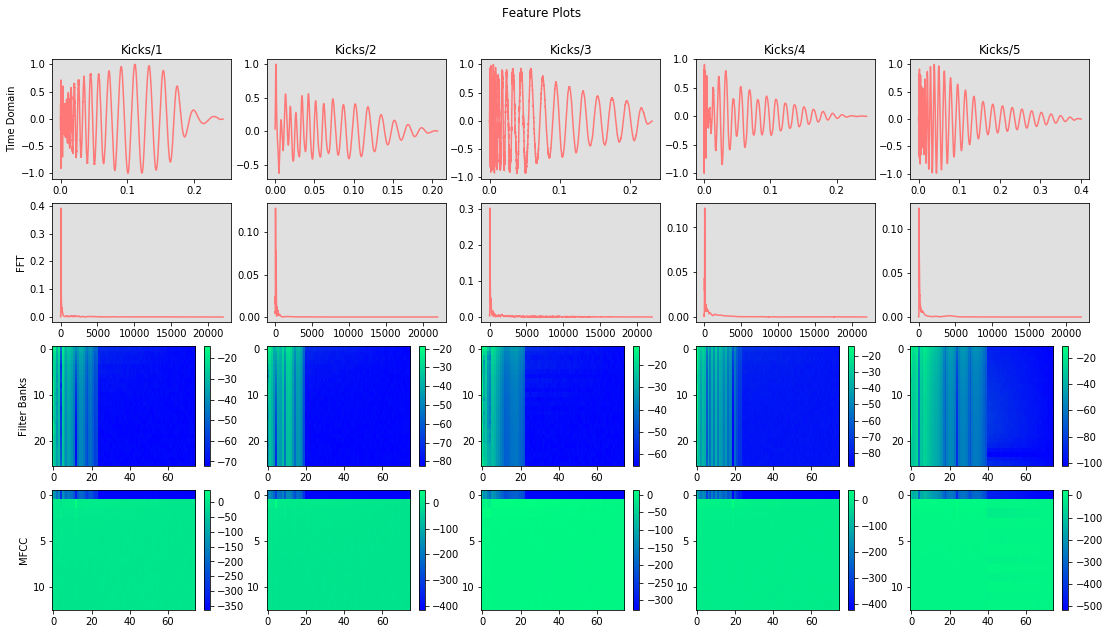

In [11]:
plot_kicks(progressBar=False)
plt.show()

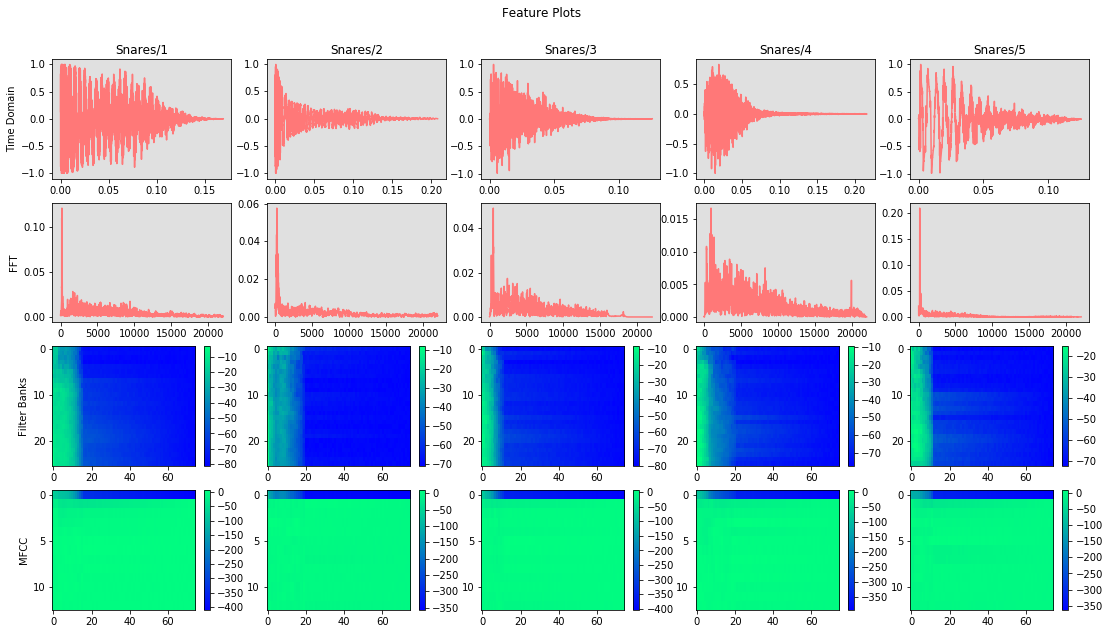

In [12]:
plot_snares(progressBar=False)
plt.show()